# Import Required Libraries
Import the necessary libraries, including pandas, geopandas, and matplotlib.

In [13]:
# Import Required Libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Ensure inline plotting for Jupyter notebooks
%matplotlib inline

# Load GeoJSON Map of Ecuador
Load the GeoJSON map of Ecuador using geopandas.

In [14]:
# Load GeoJSON Map of Ecuador
ecuador_map = gpd.read_file(
    "https://raw.githubusercontent.com/jpmarindiaz/geo-collection/master/ecu/ecuador.geojson"
)

# Display the first few rows of the GeoDataFrame to verify the data
ecuador_map.head()

,id_prov,dpa_provin,dpa_despro,dpa_valor,dpa_anio,rei_codigo,ren_codigo,pee_codigo,codigo,codigo_1,...,promedio_e,pobres_nbi,no_pobres,pob_nopob_,densidad,edad_media,cartodb_id,created_at,updated_at,geometry
0,1,01,AZUAY,0,2012,05,01,593,1,1,...,9.01,338073,361875,699948,85.70,28.85,1,2015-04-20 23:35:12+00:00,2015-04-21 16:01:08+00:00,"POLYGON ((-78.56954 -2.55865, -78.55638 -2.560..."
1,2,02,BOLIVAR,0,2012,02,01,593,2,2,...,7.79,139044,43098,182142,46.55,29.24,2,2015-04-20 23:35:12+00:00,2015-04-21 16:01:30+00:00,"POLYGON ((-78.86209 -1.1914, -78.93792 -1.3600..."
2,3,03,CAÑAR,0,2012,05,01,593,3,3,...,7.75,150549,72654,223203,71.58,28.58,3,2015-04-20 23:35:12+00:00,2015-04-21 16:01:49+00:00,"POLYGON ((-78.56954 -2.55865, -78.61701 -2.628..."
3,4,04,CARCHI,0,2012,04,01,593,4,4,...,8.36,93049,69728,162777,43.52,29.74,4,2015-04-20 23:35:12+00:00,2015-04-21 16:01:54+00:00,"POLYGON ((-77.53187 0.65236, -77.65643 0.64755..."
4,5,05,COTOPAXI,0,2012,02,01,593,5,5,...,7.82,304474,101152,405626,66.99,28.04,5,2015-04-20 23:35:12+00:00,2015-04-21 16:02:12+00:00,"POLYGON ((-78.42185 -0.71691, -78.39141 -0.748..."


# Load and Process TikTok Data
Load the TikTok data from an Excel file and process it to count comments and posts by province.

In [15]:
# Load and Process TikTok Data

# Load the Excel file containing TikTok data
tik_tok_data = pd.ExcelFile("data/append_tik_tok.xlsx")

# Parse the TikTok data sheet
tik_toks = tik_tok_data.parse("tik_toks")

# Define a function to count comments in a post
def count_comments(row):
    if pd.isna(row):
        return 0
    return len(row.split("|"))

# Apply the function to count comments and add a posts count column
tik_toks["comments_count"] = tik_toks["comments_text"].apply(count_comments)
tik_toks["posts_count"] = 1  # Each row is a post

# Correct province names in TikTok data
tik_toks['city'] = tik_toks['city'].replace({
    'santo domingo': 'santo domingo de los tsachilas',
    'manabí': 'manabi',
    'los ríos': 'los rios'
})

# Group by province and sum the comments and posts counts
comments_by_province_tiktok = (
    tik_toks.groupby("city")[["comments_count", "posts_count"]].sum().reset_index()
)
comments_by_province_tiktok.rename(columns={"city": "province"}, inplace=True)
comments_by_province_tiktok.columns = ["province", "tiktok_comments_count", "tiktok_posts_count"]

# Display the processed TikTok data
comments_by_province_tiktok.head()

,province,tiktok_comments_count,tiktok_posts_count
0,esmeraldas,249,17
1,guayas,27996,1030
2,los rios,90,3
3,manabi,21,2
4,santo domingo de los tsachilas,64,5


# Load and Process Twitter Data
Load the Twitter data from an Excel file and process it to count comments and posts by province.

In [16]:
# Load and Process Twitter Data

# Load the Excel file containing Twitter data
tweets_data = pd.ExcelFile("data/append_tweets.xlsx")

# Parse the Tweets data sheet
tweets = tweets_data.parse("tweets")

# Define a function to infer province based on keywords
def infer_province(row):
    if pd.isna(row):
        return None
    row = row.lower()
    if "quito" in row or "pichincha" in row:
        return "pichincha"
    if "guayas" in row:
        return "guayas"
    return None

# Fill missing city values based on keywords
tweets["city"] = tweets["city"].fillna(tweets["keyword"].apply(infer_province))
tweets["city"] = tweets["city"].fillna("Unknown")

# Separate posts and comments
tweets["posts_count"] = tweets["parent_tweet_url"].isna().astype(int)
tweets["comments_count"] = tweets["parent_tweet_url"].notna().astype(int)

# Aggregate Tweet counts by province
tweets_by_province = (
    tweets.groupby("city")[["posts_count", "comments_count"]].sum().reset_index()
)
tweets_by_province.rename(columns={"city": "province"}, inplace=True)
tweets_by_province.columns = ["province", "twitter_posts_count", "twitter_comments_count"]

# Display the processed Twitter data
tweets_by_province.head()

,province,twitter_posts_count,twitter_comments_count
0,Unknown,170,94
1,guayas,756,119
2,pichincha,70,114


# Merge TikTok and Twitter Data
Merge the processed TikTok and Twitter data into a single DataFrame.

In [17]:
# Merge TikTok and Twitter Data

# Merge TikTok and Twitter data on the province column
combined_data = pd.merge(
    comments_by_province_tiktok, tweets_by_province, on="province", how="outer"
).fillna(0)

# Display the combined data
combined_data.head()

,province,tiktok_comments_count,tiktok_posts_count,twitter_posts_count,twitter_comments_count
0,Unknown,0.0,0.0,170.0,94.0
1,esmeraldas,249.0,17.0,0.0,0.0
2,guayas,27996.0,1030.0,756.0,119.0
3,los rios,90.0,3.0,0.0,0.0
4,manabi,21.0,2.0,0.0,0.0


# Prepare Data for Mapping
Prepare the combined data for mapping by merging it with the GeoJSON map data.

In [18]:
# Prepare Data for Mapping

# Convert province names to lowercase for consistent merging
ecuador_map["province"] = ecuador_map["dpa_despro"].str.lower()
combined_data["province"] = combined_data["province"].str.lower()

# Merge the GeoJSON map data with the combined TikTok and Twitter data
map_data = ecuador_map.merge(combined_data, on="province", how="left").fillna(0)

# Display the first few rows of the merged map data to verify the merge
map_data.head()

,id_prov,dpa_provin,dpa_despro,dpa_valor,dpa_anio,rei_codigo,ren_codigo,pee_codigo,codigo,codigo_1,...,edad_media,cartodb_id,created_at,updated_at,geometry,province,tiktok_comments_count,tiktok_posts_count,twitter_posts_count,twitter_comments_count
0,1,01,AZUAY,0,2012,05,01,593,1,1,...,28.85,1,2015-04-20 23:35:12+00:00,2015-04-21 16:01:08+00:00,"POLYGON ((-78.56954 -2.55865, -78.55638 -2.560...",azuay,0.0,0.0,0.0,0.0
1,2,02,BOLIVAR,0,2012,02,01,593,2,2,...,29.24,2,2015-04-20 23:35:12+00:00,2015-04-21 16:01:30+00:00,"POLYGON ((-78.86209 -1.1914, -78.93792 -1.3600...",bolivar,0.0,0.0,0.0,0.0
2,3,03,CAÑAR,0,2012,05,01,593,3,3,...,28.58,3,2015-04-20 23:35:12+00:00,2015-04-21 16:01:49+00:00,"POLYGON ((-78.56954 -2.55865, -78.61701 -2.628...",cañar,0.0,0.0,0.0,0.0
3,4,04,CARCHI,0,2012,04,01,593,4,4,...,29.74,4,2015-04-20 23:35:12+00:00,2015-04-21 16:01:54+00:00,"POLYGON ((-77.53187 0.65236, -77.65643 0.64755...",carchi,0.0,0.0,0.0,0.0
4,5,05,COTOPAXI,0,2012,02,01,593,5,5,...,28.04,5,2015-04-20 23:35:12+00:00,2015-04-21 16:02:12+00:00,"POLYGON ((-78.42185 -0.71691, -78.39141 -0.748...",cotopaxi,0.0,0.0,0.0,0.0


# Plot TikTok Comments Heatmap with Numbers
Plot a heatmap of TikTok comments by province and add numerical labels to each province.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\2885074238.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_comments_count"]):


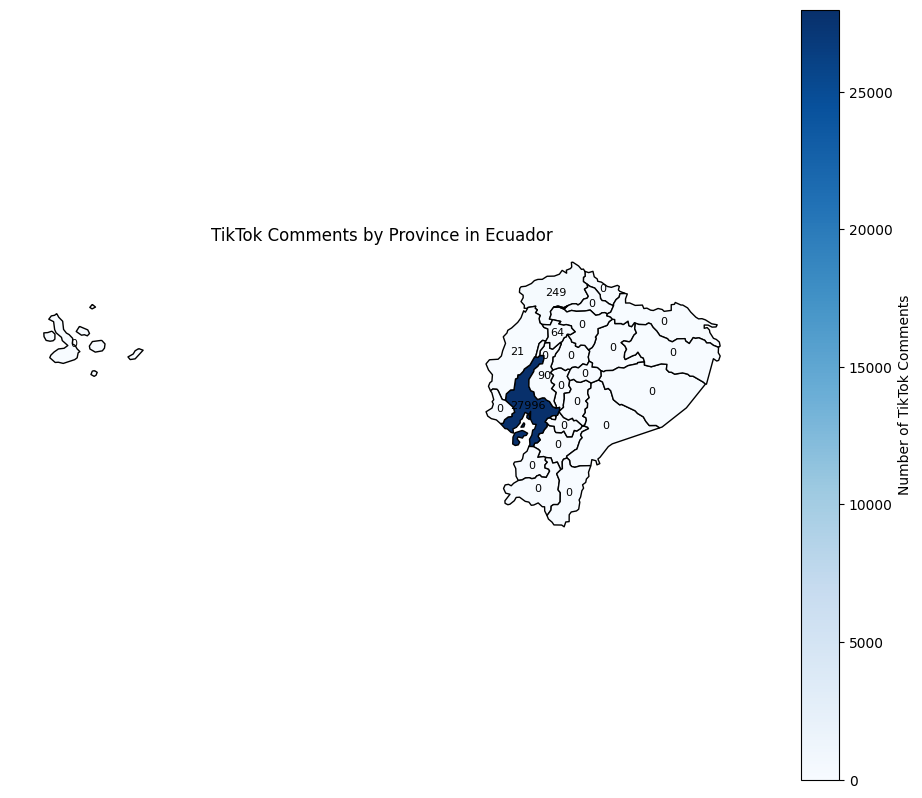

In [19]:
# Plot TikTok Comments Heatmap with Numbers

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the heatmap for TikTok comments count
map_data.plot(
    column="tiktok_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Comments"},
    cmap="Blues",
    edgecolor="black",
)

# Add numerical labels to each province
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_comments_count"]):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color='black')

ax.set_title("TikTok Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot Twitter Comments Heatmap with Numbers
Plot a heatmap of Twitter comments by province and add numerical labels to each province.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1943927643.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_comments_count"]):


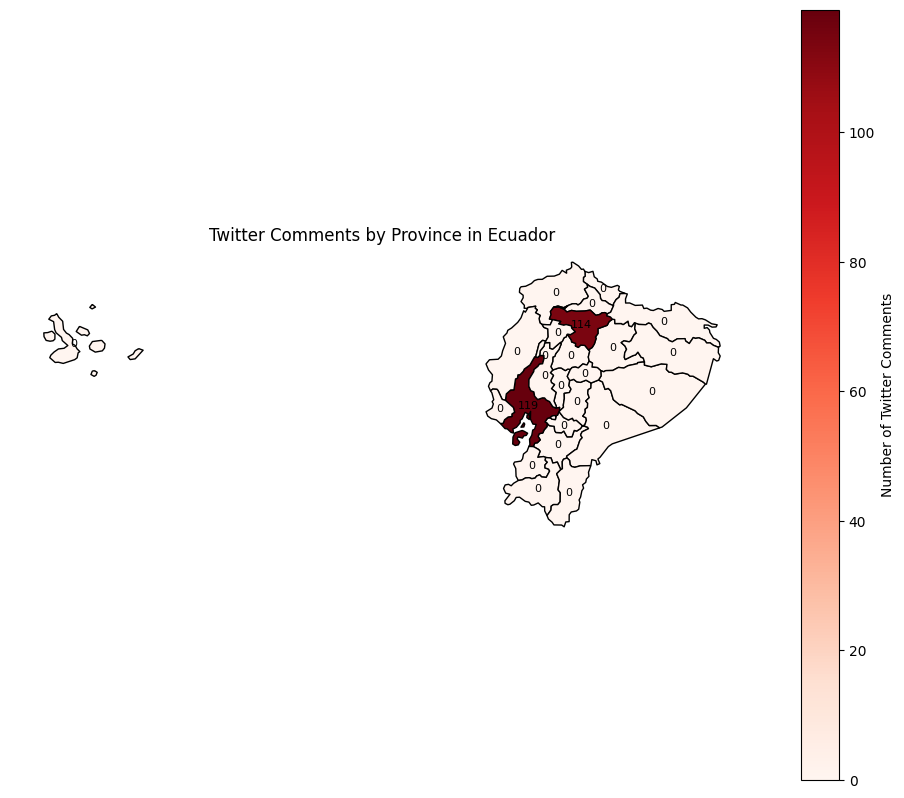

In [20]:
# Plot Twitter Comments Heatmap with Numbers

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the heatmap for Twitter comments count
map_data.plot(
    column="twitter_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Comments"},
    cmap="Reds",
    edgecolor="black",
)

# Add numerical labels to each province
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_comments_count"]):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color='black')

ax.set_title("Twitter Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot TikTok Posts Heatmap with Numbers
Plot a heatmap of TikTok posts by province and add numerical labels to each province.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1048568578.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_posts_count"]):


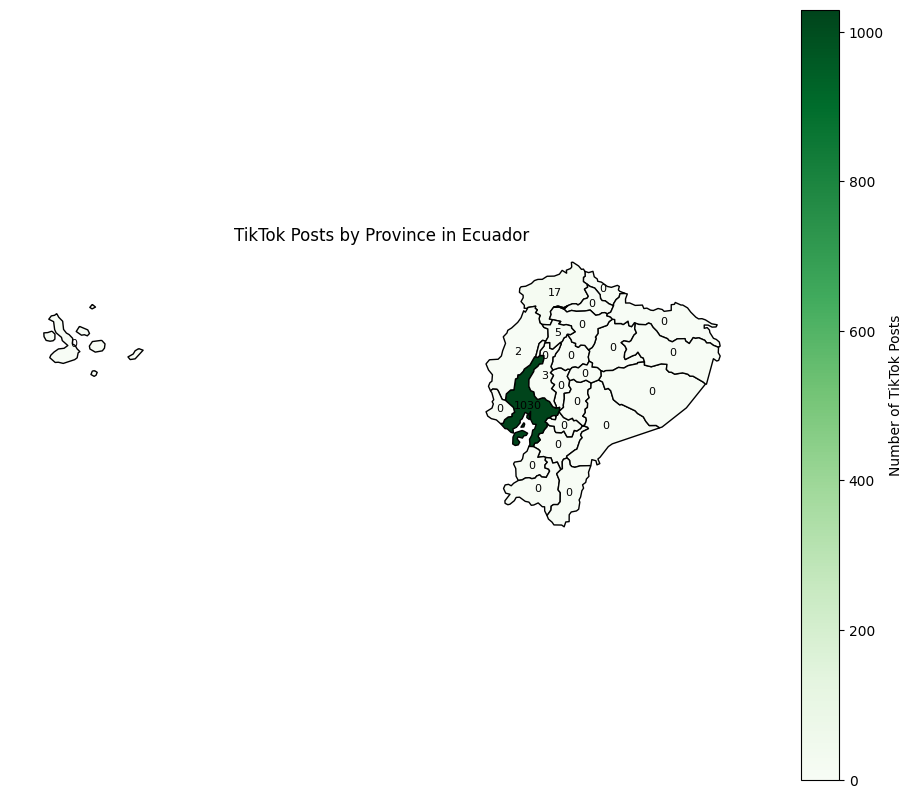

In [21]:
# Plot TikTok Posts Heatmap with Numbers

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the heatmap for TikTok posts count
map_data.plot(
    column="tiktok_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Posts"},
    cmap="Greens",
    edgecolor="black",
)

# Add numerical labels to each province
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_posts_count"]):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color='black')

ax.set_title("TikTok Posts by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot Twitter Posts Heatmap with Numbers
Plot a heatmap of Twitter posts by province and add numerical labels to each province.

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\2554332287.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_posts_count"]):


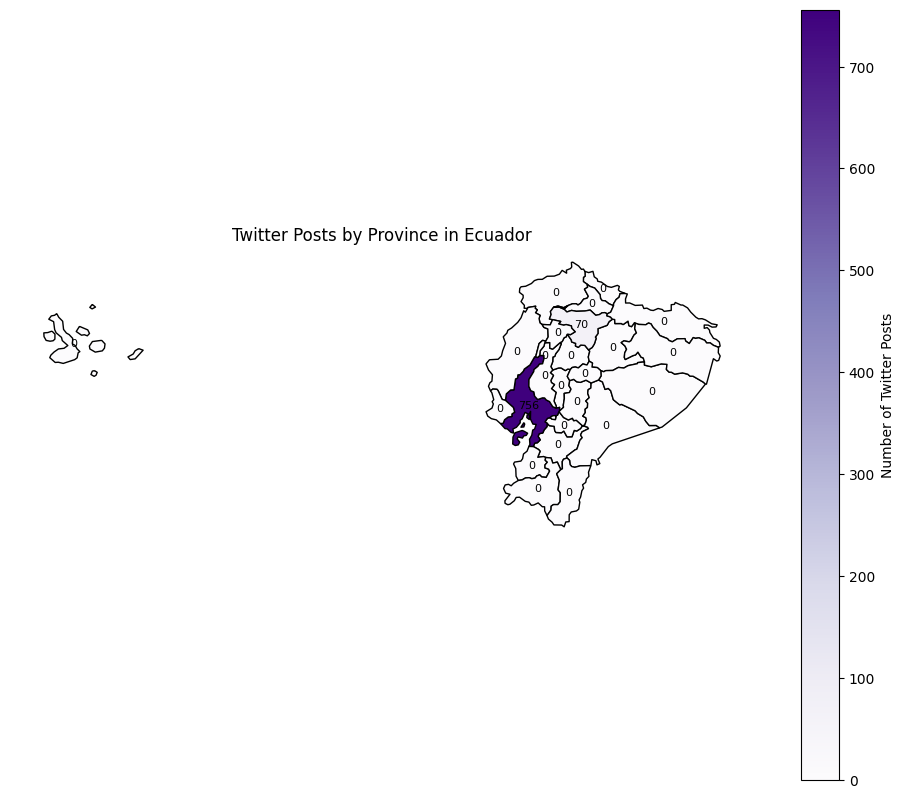

In [22]:
# Plot Twitter Posts Heatmap with Numbers

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot the heatmap for Twitter posts count
map_data.plot(
    column="twitter_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Posts"},
    cmap="Purples",
    edgecolor="black",
)

# Add numerical labels to each province
for x, y, label in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_posts_count"]):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color='black')

ax.set_title("Twitter Posts by Province in Ecuador")
plt.axis("off")
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1472552484.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_comments_count"], text_colors):


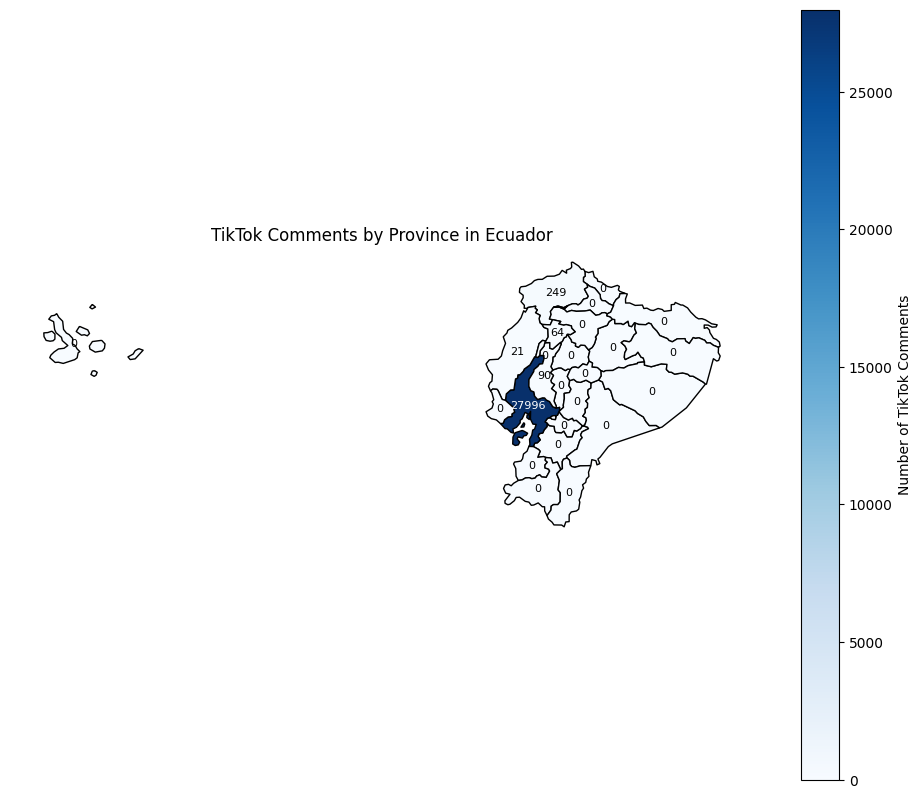

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1472552484.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_comments_count"], text_colors):


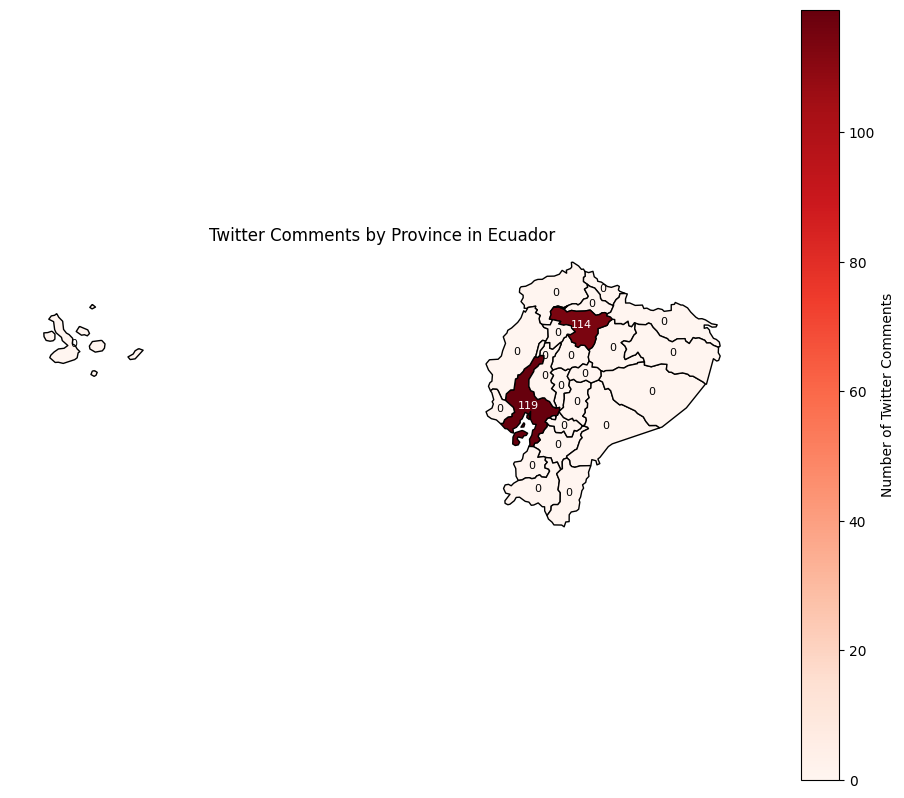

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1472552484.py:63: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_posts_count"], text_colors):


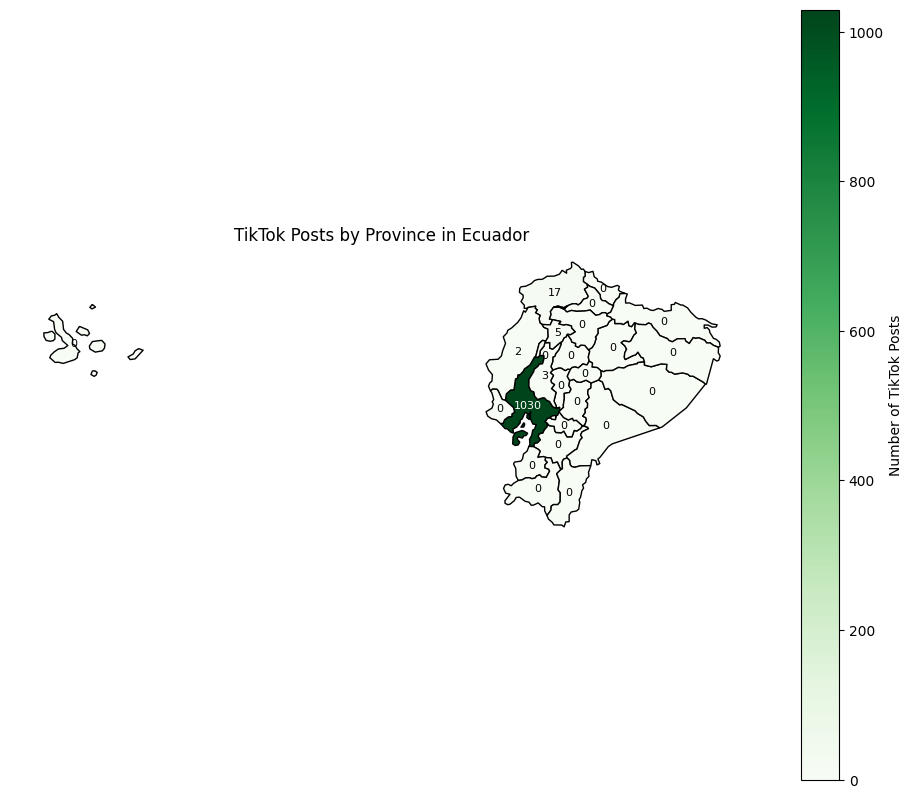

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1472552484.py:81: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_posts_count"], text_colors):


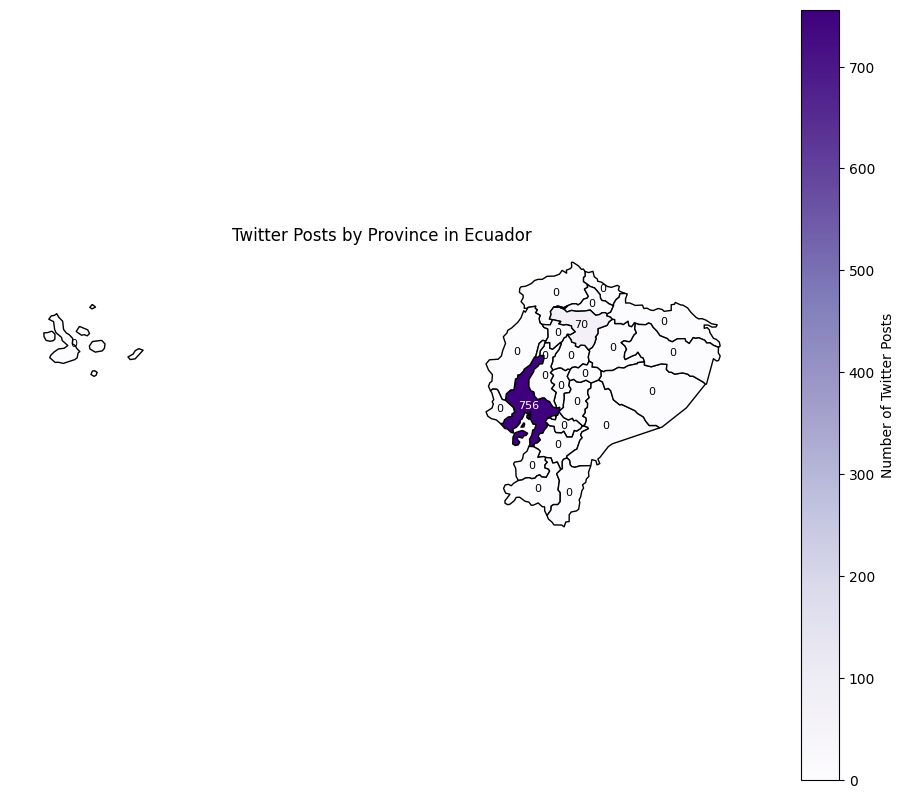

In [23]:
# Convert province names to lowercase for consistent merging
ecuador_map["province"] = ecuador_map["dpa_despro"].str.lower()
combined_data["province"] = combined_data["province"].str.lower()

# Merge the GeoJSON map data with the combined TikTok and Twitter data
map_data = ecuador_map.merge(combined_data, on="province", how="left").fillna(0)

# Function to determine text color based on background color
def get_text_color(value, cmap):
    norm = plt.Normalize(vmin=map_data[value].min(), vmax=map_data[value].max())
    rgba = cmap(norm(map_data[value]))
    luminance = 0.299 * rgba[:, 0] + 0.587 * rgba[:, 1] + 0.114 * rgba[:, 2]
    return ['white' if lum < 0.5 else 'black' for lum in luminance]

# Plot TikTok Comments Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Blues
map_data.plot(
    column="tiktok_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Comments"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("tiktok_comments_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_comments_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("TikTok Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot Twitter Comments Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Reds
map_data.plot(
    column="twitter_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Comments"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("twitter_comments_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_comments_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("Twitter Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot TikTok Posts Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Greens
map_data.plot(
    column="tiktok_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Posts"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("tiktok_posts_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_posts_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("TikTok Posts by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot Twitter Posts Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Purples
map_data.plot(
    column="twitter_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Posts"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("twitter_posts_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_posts_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("Twitter Posts by Province in Ecuador")
plt.axis("off")
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1024537644.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data_tiktok_comments.geometry.centroid.x, map_data_tiktok_comments.geometry.centroid.y, map_data_tiktok_comments["tiktok_comments_count"], text_colors):


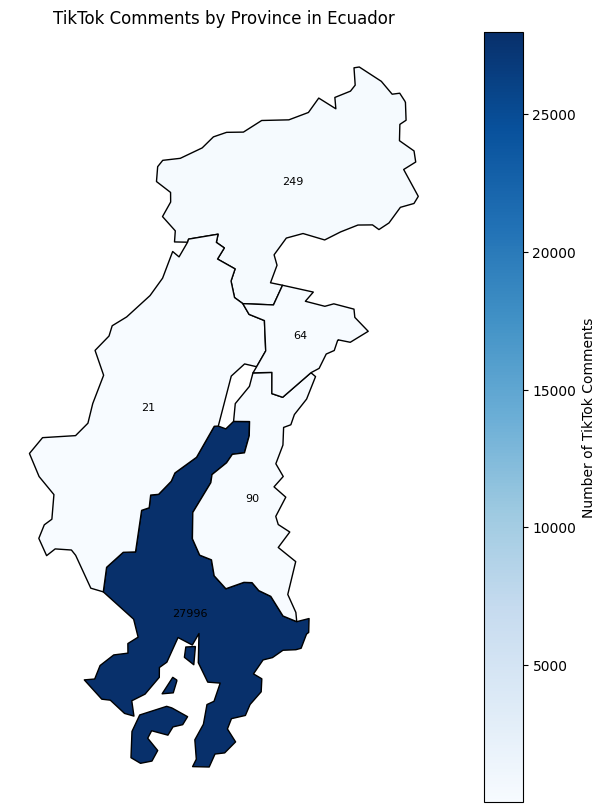

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1024537644.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data_twitter_comments.geometry.centroid.x, map_data_twitter_comments.geometry.centroid.y, map_data_twitter_comments["twitter_comments_count"], text_colors):


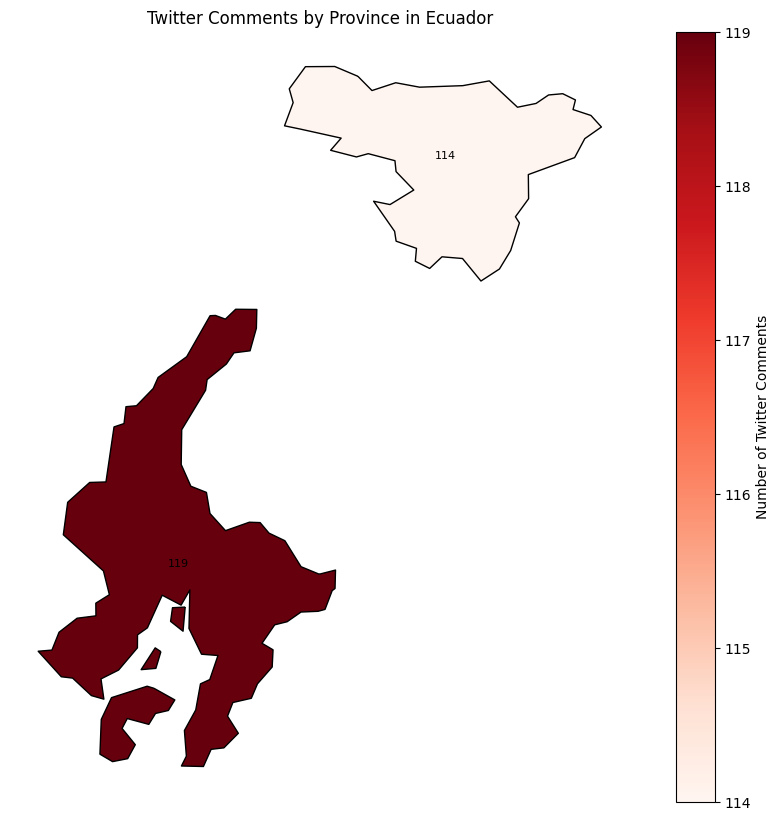

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1024537644.py:58: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data_tiktok_posts.geometry.centroid.x, map_data_tiktok_posts.geometry.centroid.y, map_data_tiktok_posts["tiktok_posts_count"], text_colors):


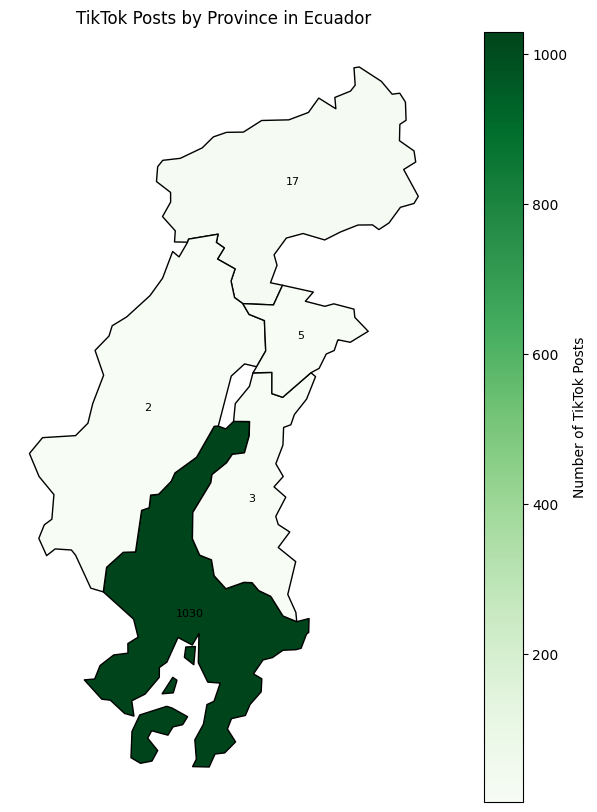

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\1024537644.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data_twitter_posts.geometry.centroid.x, map_data_twitter_posts.geometry.centroid.y, map_data_twitter_posts["twitter_posts_count"], text_colors):


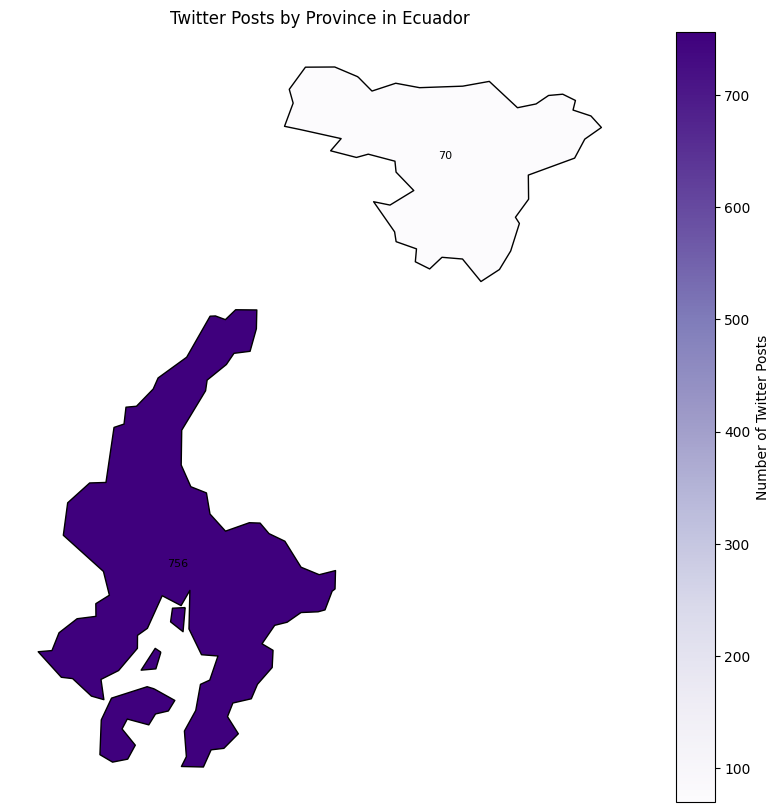

In [24]:
# Filter out provinces with 0 counts for TikTok comments
map_data_tiktok_comments = map_data[map_data["tiktok_comments_count"] > 0]

# Plot TikTok Comments Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Blues
map_data_tiktok_comments.plot(
    column="tiktok_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Comments"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("tiktok_comments_count", cmap)
for x, y, label, color in zip(map_data_tiktok_comments.geometry.centroid.x, map_data_tiktok_comments.geometry.centroid.y, map_data_tiktok_comments["tiktok_comments_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("TikTok Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Filter out provinces with 0 counts for Twitter comments
map_data_twitter_comments = map_data[map_data["twitter_comments_count"] > 0]

# Plot Twitter Comments Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Reds
map_data_twitter_comments.plot(
    column="twitter_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Comments"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("twitter_comments_count", cmap)
for x, y, label, color in zip(map_data_twitter_comments.geometry.centroid.x, map_data_twitter_comments.geometry.centroid.y, map_data_twitter_comments["twitter_comments_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("Twitter Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Filter out provinces with 0 counts for TikTok posts
map_data_tiktok_posts = map_data[map_data["tiktok_posts_count"] > 0]

# Plot TikTok Posts Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Greens
map_data_tiktok_posts.plot(
    column="tiktok_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Posts"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("tiktok_posts_count", cmap)
for x, y, label, color in zip(map_data_tiktok_posts.geometry.centroid.x, map_data_tiktok_posts.geometry.centroid.y, map_data_tiktok_posts["tiktok_posts_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("TikTok Posts by Province in Ecuador")
plt.axis("off")
plt.show()

# Filter out provinces with 0 counts for Twitter posts
map_data_twitter_posts = map_data[map_data["twitter_posts_count"] > 0]

# Plot Twitter Posts Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Purples
map_data_twitter_posts.plot(
    column="twitter_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Posts"},
    cmap=cmap,
    edgecolor="black",
)
text_colors = get_text_color("twitter_posts_count", cmap)
for x, y, label, color in zip(map_data_twitter_posts.geometry.centroid.x, map_data_twitter_posts.geometry.centroid.y, map_data_twitter_posts["twitter_posts_count"], text_colors):
    ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("Twitter Posts by Province in Ecuador")
plt.axis("off")
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\3610790299.py:21: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_comments_count"], text_colors):


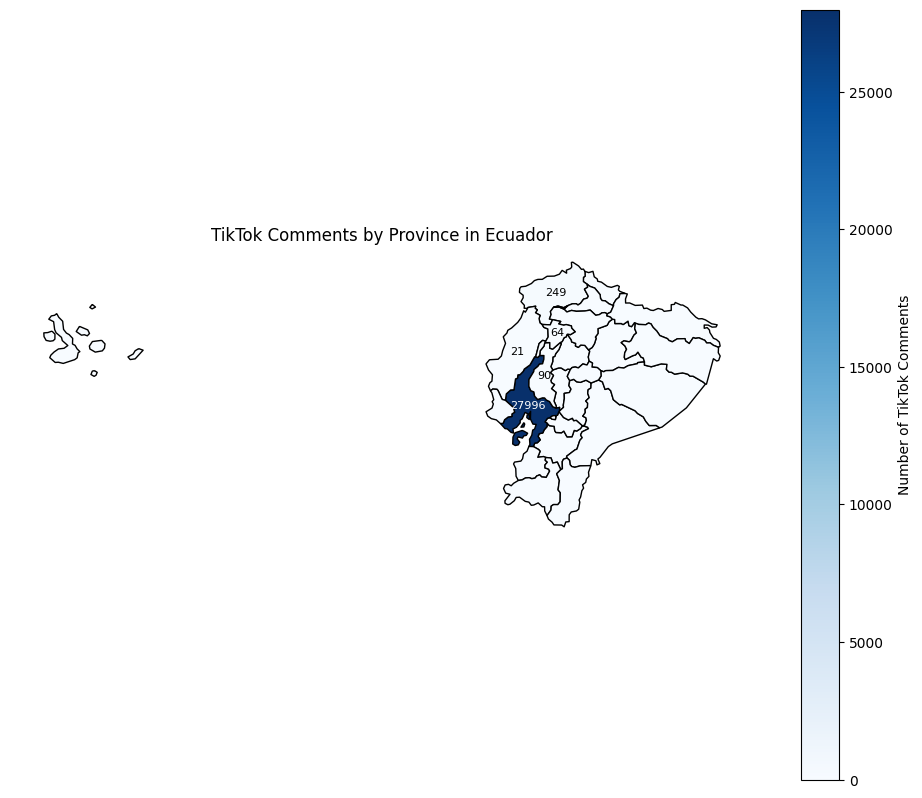

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\3610790299.py:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_comments_count"], text_colors):


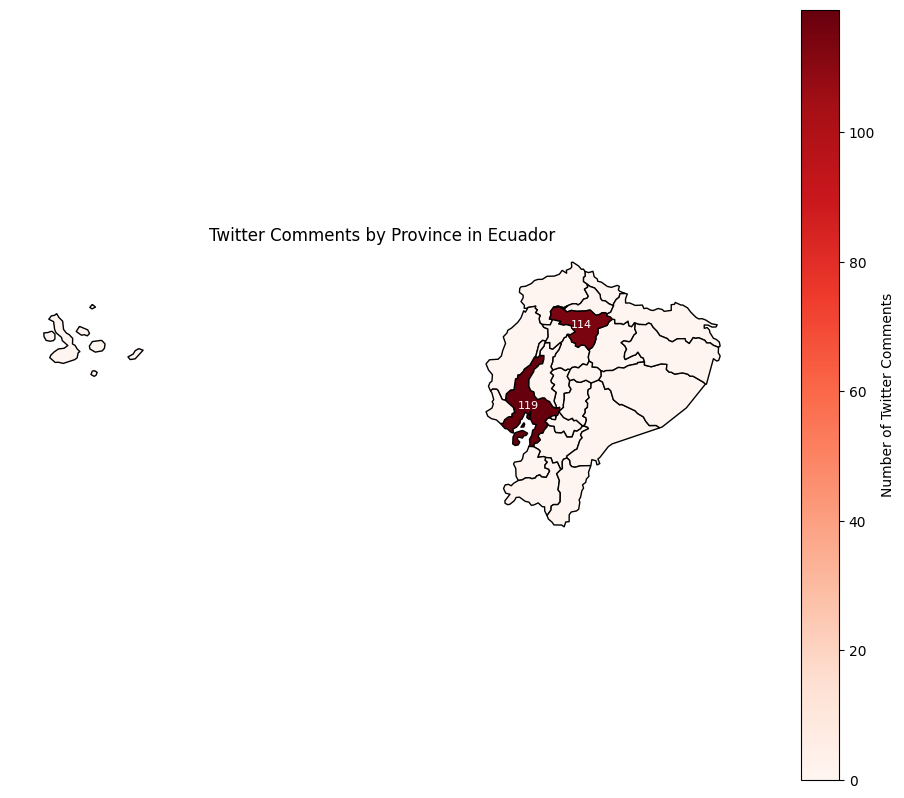

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\3610790299.py:61: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_posts_count"], text_colors):


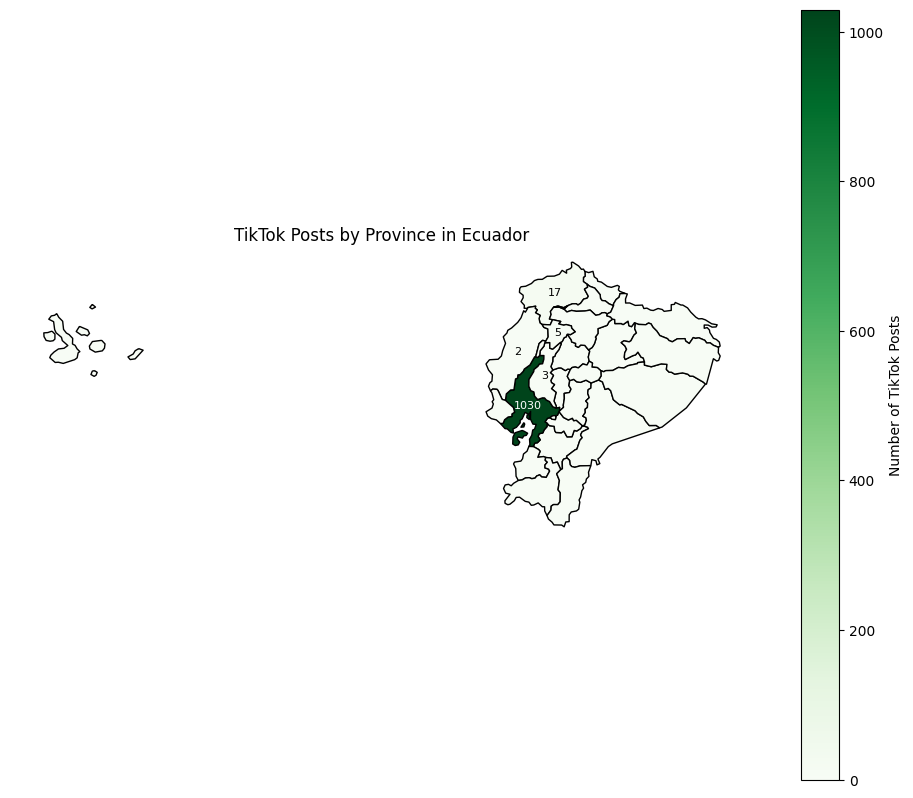

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4532\3610790299.py:81: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_posts_count"], text_colors):


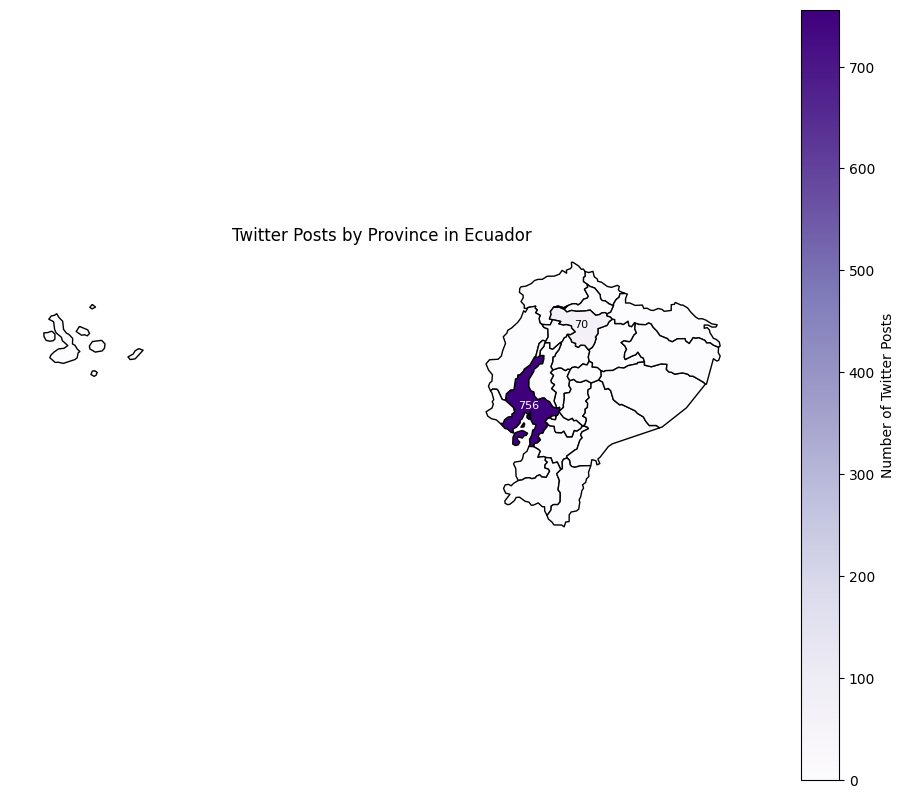

In [25]:
# Function to determine text color based on background color
def get_text_color(value, cmap):
    norm = plt.Normalize(vmin=map_data[value].min(), vmax=map_data[value].max())
    rgba = cmap(norm(map_data[value]))
    luminance = 0.299 * rgba[:, 0] + 0.587 * rgba[:, 1] + 0.114 * rgba[:, 2]
    return ['white' if lum < 0.5 else 'black' for lum in luminance]

# Plot TikTok Comments Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Blues
map_data.plot(
    column="tiktok_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Comments"},
    cmap=cmap,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)
text_colors = get_text_color("tiktok_comments_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_comments_count"], text_colors):
    if label > 0:
        ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("TikTok Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot Twitter Comments Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Reds
map_data.plot(
    column="twitter_comments_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Comments"},
    cmap=cmap,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)
text_colors = get_text_color("twitter_comments_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_comments_count"], text_colors):
    if label > 0:
        ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("Twitter Comments by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot TikTok Posts Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Greens
map_data.plot(
    column="tiktok_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of TikTok Posts"},
    cmap=cmap,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)
text_colors = get_text_color("tiktok_posts_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["tiktok_posts_count"], text_colors):
    if label > 0:
        ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("TikTok Posts by Province in Ecuador")
plt.axis("off")
plt.show()

# Plot Twitter Posts Heatmap with Numbers
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
cmap = plt.cm.Purples
map_data.plot(
    column="twitter_posts_count",
    ax=ax,
    legend=True,
    legend_kwds={"label": "Number of Twitter Posts"},
    cmap=cmap,
    edgecolor="black",
    missing_kwds={"color": "lightgrey"}
)
text_colors = get_text_color("twitter_posts_count", cmap)
for x, y, label, color in zip(map_data.geometry.centroid.x, map_data.geometry.centroid.y, map_data["twitter_posts_count"], text_colors):
    if label > 0:
        ax.text(x, y, int(label), fontsize=8, ha='center', va='center', color=color)
ax.set_title("Twitter Posts by Province in Ecuador")
plt.axis("off")
plt.show()